In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from lime.lime_tabular import LimeTabularExplainer

import scikitplot as skplt

import warnings
warnings.filterwarnings("ignore")

In [2]:
%reload_ext watermark
%watermark -a "Modelo Classificador - Churn"
%watermark --iversions

Author: Modelo Classificador - Churn

matplotlib : 3.9.4
numpy      : 1.25.2
seaborn    : 0.13.2
sklearn    : 1.6.1
lime       : 0.2.0.1
statsmodels: 0.14.4
scikitplot : 0.3.7
json       : 2.0.9
pandas     : 2.2.3



In [3]:
with open('dicionario_de_dados.json',
         'r') as arquivo:
    dicionario_de_dados = json.load(arquivo)



df_dict = pd.DataFrame.from_dict(dicionario_de_dados, orient='index')
df_dict

,descrição,tipo
TEMPO_PERMANENCIA_CLIENTE_MESES,"Tempo, em meses, que o cliente está ativo.",int
B,Quantidade de solicitações do serviço mascarad...,int
C,Quantidade de solicitações do serviço mascarad...,int
D,Quantidade de solicitações do serviço mascarad...,int
E,Quantidade de solicitações do serviço mascarad...,int
G,Quantidade de solicitações do serviço mascarad...,int
H,Quantidade de solicitações do serviço mascarad...,int
J,Quantidade de solicitações do serviço mascarad...,int
OUTROS,Soma de solicitações de serviços menos frequen...,int
TOTAL_DOLAR_FATURADO,Total faturado em dólar.,float


In [4]:
df_ml = pd.read_csv('datasets/df_ml.csv')
df_ml.ID = df_ml.ID.astype(int)

display(df_ml.head())
print(df_ml.shape)

,ID,TEMPO_PERMANENCIA_CLIENTE_MESES,B,C,D,E,G,H,J,OUTROS,TOTAL_DOLAR_FATURADO,TICKET_MEDIO,RECENCIA,FREQUENCIA,VALOR,CHURN
0,1,111.0,30,30,6,6,30,30,36,0,46430.26,7738.376667,1096.0,6.0,8.0,0
1,2,0.0,1,0,0,1,0,0,0,0,2900.00,2900.000000,6636.0,1.0,1.0,0
2,3,333.0,98530,78991,2672,38076,118403,108383,137274,19873,3074863.95,18412.358982,183.0,167.0,1115.0,1
3,4,0.0,0,2,0,0,2,0,2,0,4475.50,4475.500000,2467.0,1.0,2.0,1
4,5,185.0,36,12,0,24,24,0,12,12,20573.26,1714.438333,1218.0,12.0,12.0,1


(1596, 16)


In [5]:
df_ml.isna().sum()

ID                                 0
TEMPO_PERMANENCIA_CLIENTE_MESES    0
B                                  0
C                                  0
D                                  0
E                                  0
G                                  0
H                                  0
J                                  0
OUTROS                             0
TOTAL_DOLAR_FATURADO               1
TICKET_MEDIO                       1
RECENCIA                           1
FREQUENCIA                         1
VALOR                              1
CHURN                              0
dtype: int64

In [6]:
df_ml.dropna(inplace=True)
df_ml.isna().sum()

ID                                 0
TEMPO_PERMANENCIA_CLIENTE_MESES    0
B                                  0
C                                  0
D                                  0
E                                  0
G                                  0
H                                  0
J                                  0
OUTROS                             0
TOTAL_DOLAR_FATURADO               0
TICKET_MEDIO                       0
RECENCIA                           0
FREQUENCIA                         0
VALOR                              0
CHURN                              0
dtype: int64

In [7]:
X = df_ml.drop(columns=['ID',
                        'CHURN'])
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.to_markdown(index=False, tablefmt='pipe'))

| Variable                        |       VIF |
|:--------------------------------|----------:|
| const                           |   9.39571 |
| TEMPO_PERMANENCIA_CLIENTE_MESES |   2.34509 |
| B                               |  66.2164  |
| C                               |  45.5679  |
| D                               |   4.37447 |
| E                               |  53.6994  |
| G                               | 181.429   |
| H                               |  16.4227  |
| J                               | 185.987   |
| OUTROS                          |   8.01436 |
| TOTAL_DOLAR_FATURADO            |  23.812   |
| TICKET_MEDIO                    |   1.65838 |
| RECENCIA                        |   1.52161 |
| FREQUENCIA                      |  18.7752  |
| VALOR                           |  26.4389  |


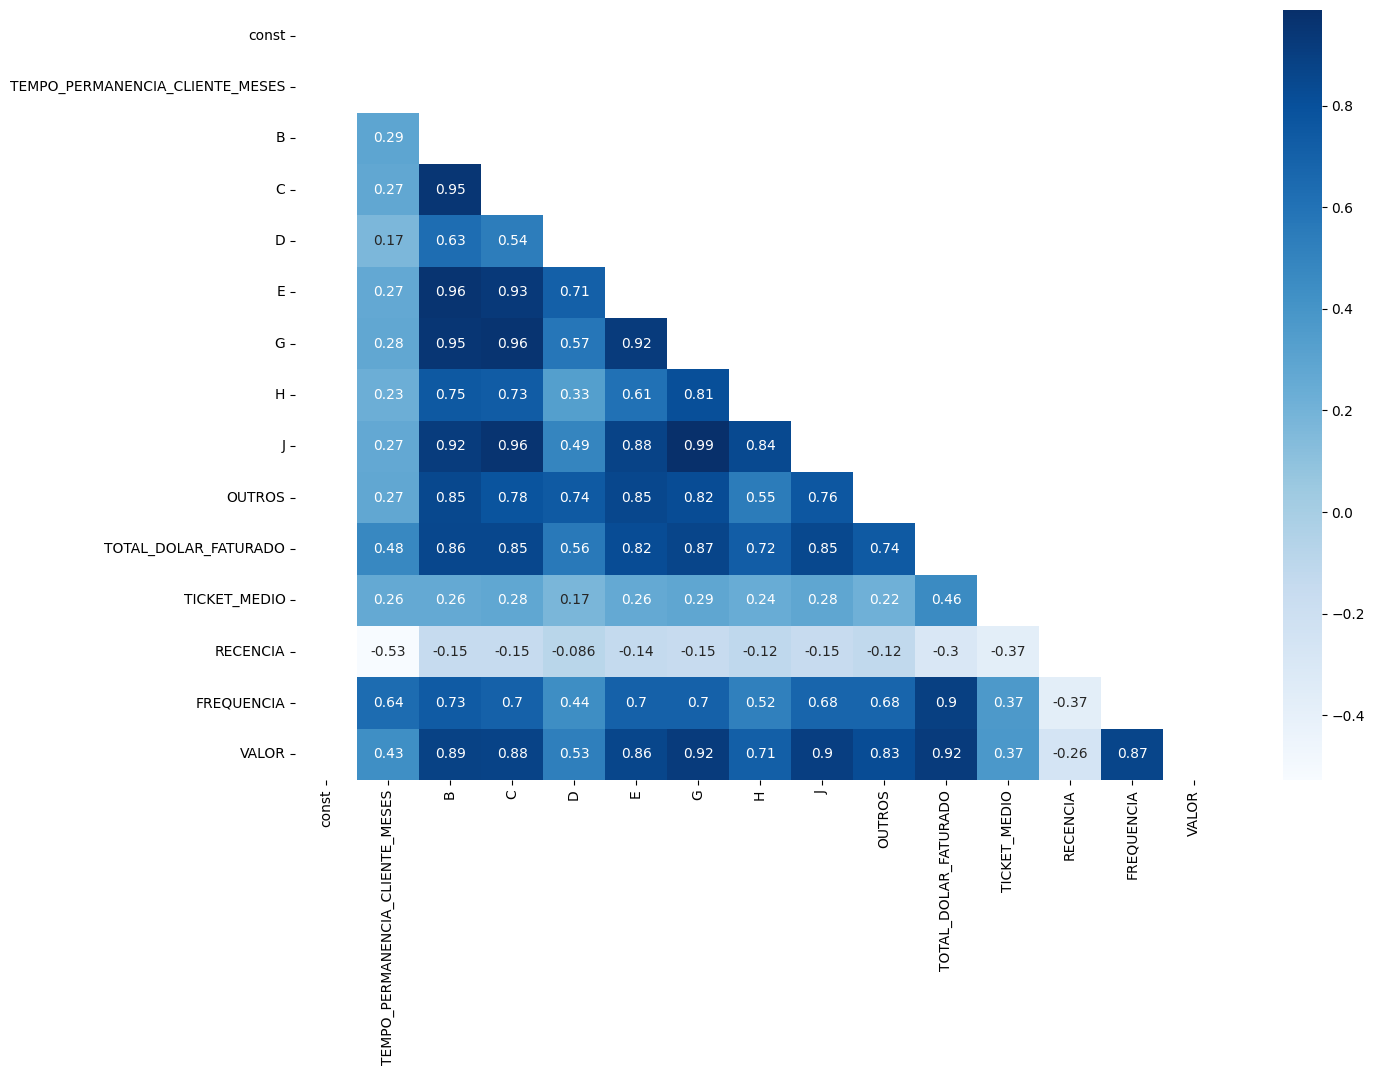

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='Blues',
            mask=mask,
            ax=ax)
plt.show()

### VIF de modo iterativo

In [9]:
def remover_vif_alto(df, target='CHURN', limiar=10):
    X = df.drop(columns=['ID', target]).copy()
    while True:
        X_const = sm.add_constant(X)
        vif = pd.DataFrame()
        vif["Variable"] = X_const.columns
        vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
        vif = vif[vif["Variable"] != "const"]
        max_vif = vif["VIF"].max()
        if max_vif < limiar:
            break
        var_remover = vif.sort_values("VIF", ascending=False).iloc[0]["Variable"]
        X = X.drop(columns=[var_remover])
    return X

X_filtrado = remover_vif_alto(df_ml, target='CHURN', limiar=10)
X_const = sm.add_constant(X_filtrado)

vif_data = pd.DataFrame()
vif_data['Variable'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data.to_markdown(index=False, tablefmt='pipe'))

| Variable                        |     VIF |
|:--------------------------------|--------:|
| const                           | 8.80742 |
| TEMPO_PERMANENCIA_CLIENTE_MESES | 2.20005 |
| C                               | 4.34439 |
| D                               | 2.29393 |
| H                               | 2.17447 |
| OUTROS                          | 4.53813 |
| TICKET_MEDIO                    | 1.27407 |
| RECENCIA                        | 1.51482 |
| FREQUENCIA                      | 3.8956  |


Log-Likelihood Ratio (Razão de Verossimilhança Logarítmica)

In [10]:
variaveis = [
    'TEMPO_PERMANENCIA_CLIENTE_MESES','TICKET_MEDIO','RECENCIA',
    'FREQUENCIA','C', 'D', 'H', 'OUTROS'
]

base_formula = 'CHURN ~ '
melhores = []
resultados = []

for var in variaveis:
    formula = base_formula + ' + '.join(melhores + [var])
    modelo = smf.logit(formula=formula, data=df_ml).fit(disp=0)
    llr_pvalue = modelo.llr_pvalue
    resultados.append((var, llr_pvalue))
    melhores.append(var)

df_resultado = pd.DataFrame(resultados, columns=['Variavel', 'LLR_pvalue'])

In [11]:
df_resultado

,Variavel,LLR_pvalue
0,TEMPO_PERMANENCIA_CLIENTE_MESES,3.824452e-10
1,TICKET_MEDIO,9.988061e-34
2,RECENCIA,6.914047e-63
3,FREQUENCIA,3.587691e-62
4,C,9.373182e-62
5,D,7.583262e-61
6,H,3.935467e-60
7,OUTROS,1.755240e-59


In [12]:
df_ml2 = df_ml[[
                'TEMPO_PERMANENCIA_CLIENTE_MESES',
                'TICKET_MEDIO',
                'RECENCIA',
                'FREQUENCIA',
                'C', 'D', 'H', 'OUTROS',
                'CHURN'
              ]]


X = df_ml2.drop(columns=['CHURN'])
y = df_ml2['CHURN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_rf = RandomForestClassifier(random_state=42)

In [13]:
param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(start=10, stop=200, num=10)],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 100, num=10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
model_rf = random_search.best_estimator_

best_random = random_search.best_estimator_
y_pred = best_random.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [14]:
y_pred = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [15]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, '{:0.4f}'.format(cm[i, j]),
                    horizontalalignment='center',
                    color='white' if cm[i, j] > thresh else 'black')
        else:
            plt.text(j, i, '{:,}'.format(cm[i, j]),
                    horizontalalignment='center',
                    color='white' if cm[i, j] > thresh else 'black')
            
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

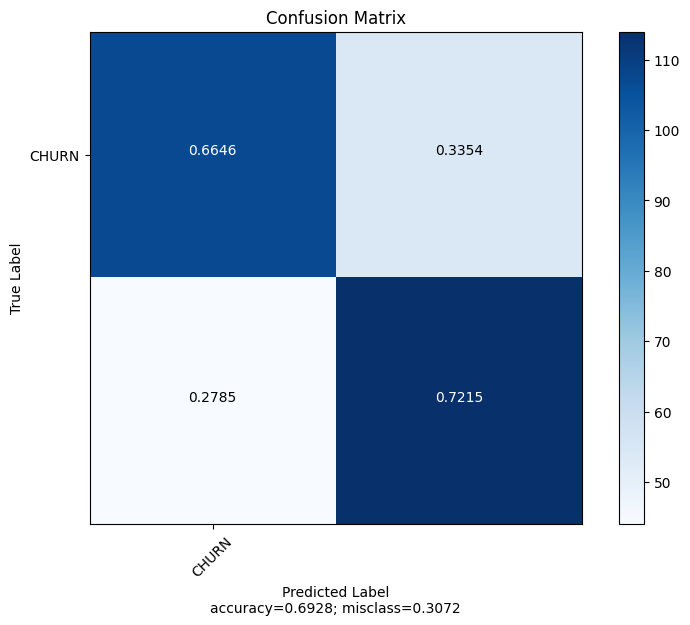

In [16]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['CHURN'])

### Veja de cima para baixo, da esquerda para direita
- Verdadeiro Negativo (TN): falou que não é Churn e acertou
- Falso Negativo (FN): falou que não é Churn e errou, na verdade é
- Falso Positivo (FP): falou que é Churn e não é
- Verdadeiro Positivo (TP): falou que é Churn e de fato é, acertou

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
 
$Precision = \frac{TP}{TP + FP}$
  
$Recall = \frac{TP}{TP + FN}$
  
$F1 = \frac{2 \cdot Recall \cdot Precision}{Recall + Precision}$

In [17]:
feature_importance = model_rf.feature_importances_
feature_importance_df = pd.DataFrame({'FEATURE': X.columns, 'IMPORTANCE': feature_importance})
feature_importance_df.sort_values(by='IMPORTANCE', ascending=False, inplace=True)
feature_importance_df.head(10)

,FEATURE,IMPORTANCE
2,RECENCIA,0.375854
1,TICKET_MEDIO,0.214115
0,TEMPO_PERMANENCIA_CLIENTE_MESES,0.088694
4,C,0.079268
6,H,0.068056
5,D,0.062935
7,OUTROS,0.062908
3,FREQUENCIA,0.048170


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

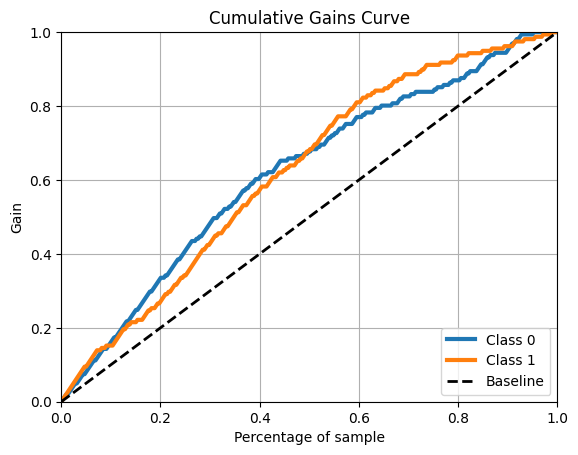

In [18]:
y_proba = model_rf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

### Kolmogorov–Smirnov
- Usado para avaliar a separação entre as classes (0 e 1) com base nas probabilidades previstas pelo modelo
- Acima de 0.3 já mostra que está separando bem

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

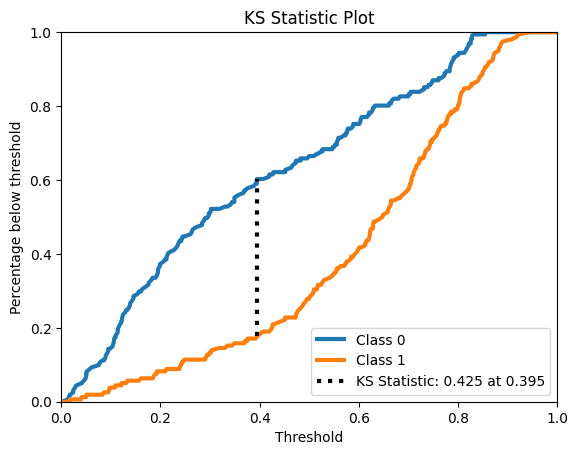

In [19]:
skplt.metrics.plot_ks_statistic(y_test, y_proba)

In [20]:
y_pred_prob = model_rf.predict_proba(X_test)[:, 1]
threshold = 0.395
y_pred = (y_pred_prob >= threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred)

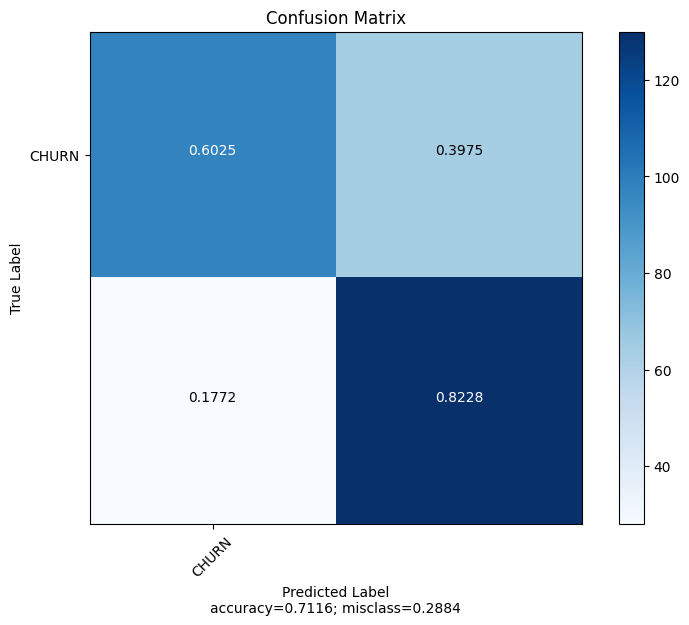

In [21]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['CHURN'])

### Interpretabilidade

In [22]:
explainer = LimeTabularExplainer(
    scaler.inverse_transform(X_train),
    mode='classification',
    feature_names=X.columns,
    class_names=['Not Churn', 'Churn'],
    discretize_continuous=True
)

instance_idx = 0
exp = explainer.explain_instance(
    scaler.inverse_transform(X_test[instance_idx].reshape(1, -1))[0],
    model_rf.predict_proba,
    num_features=10
)

exp.show_in_notebook()

In [23]:
X_instance = scaler.inverse_transform(X_test[instance_idx].reshape(1, -1))
X_mod = X_instance.copy()
X_mod[0][X.columns.get_loc('RECENCIA')] += 90

proba_original = model_rf.predict_proba(scaler.transform(X_instance))[0][1]
proba_mod = model_rf.predict_proba(scaler.transform(X_mod))[0][1]

impacto = proba_mod - proba_original
print(f"Aumento estimado na probabilidade de Churn após 90 dias: {impacto:.2%}")

Aumento estimado na probabilidade de Churn após 90 dias: 7.72%


In [24]:
churn_probabilities = y_proba[:, 1]
results = pd.DataFrame({
    'client_id': range(len(churn_probabilities)),
    'CHURN_PROBABILITY': churn_probabilities
})
results.sort_values(by='CHURN_PROBABILITY', ascending=False, inplace=True)
top_40_percent_count = int(0.4 * len(results))
top_40_percent_clients = results.head(top_40_percent_count)
df_rf = df_ml.loc[top_40_percent_clients['client_id']]
df_rf['CHURN_PROBABILITY'] = top_40_percent_clients.set_index('client_id')['CHURN_PROBABILITY']
df_rf.drop(columns=['CHURN'], inplace=True)

In [25]:
df_rf.head()

,ID,TEMPO_PERMANENCIA_CLIENTE_MESES,B,C,D,E,G,H,J,OUTROS,TOTAL_DOLAR_FATURADO,TICKET_MEDIO,RECENCIA,FREQUENCIA,VALOR,CHURN_PROBABILITY
237,238,1.0,4,0,0,4,0,0,0,0,11654.00,5827.000000,5509.0,2.0,2.0,0.945776
34,35,45.0,18,36,30,0,18,18,36,0,23015.77,3835.961667,335.0,6.0,6.0,0.921711
162,163,64.0,5,15,0,0,5,0,10,5,11428.04,2285.608000,2041.0,5.0,6.0,0.918161
25,26,214.0,32,48,8,16,80,32,48,40,45329.18,5666.147500,641.0,8.0,11.0,0.908761
284,285,53.0,310,961,62,31,341,93,992,0,143530.75,4630.024194,396.0,31.0,87.0,0.890086


In [26]:
df_rf.to_excel('datasets/resultado.xlsx', index=False)